In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import ranksums, brunnermunzel

rd = pd.read_excel('/sc/arion/projects/GENECAD/Robert/Drug_Phewas/RareDrug/Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

import os
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FuncFormatter

font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
assert os.path.exists(font_path)
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

matplotlib.rc('font', family='sans-serif')
matplotlib.rcParams.update({
    'font.size': 12,
    'font.sans-serif': prop.get_name(),
    'axes.titlesize': 12
})


## Power (figure S1)

In [36]:
power = pd.read_csv('./Resources/power.csv')

/tmp/ipykernel_11275/4201098187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Beta'] = np.log(df['OR'])
/tmp/ipykernel_11275/4201098187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Beta'] = df['Beta'].apply(lambda x: np.round(x, -int(np.floor(np.log10(abs(x))))))


Text(95.66666666666667, 0.5, 'MAF')

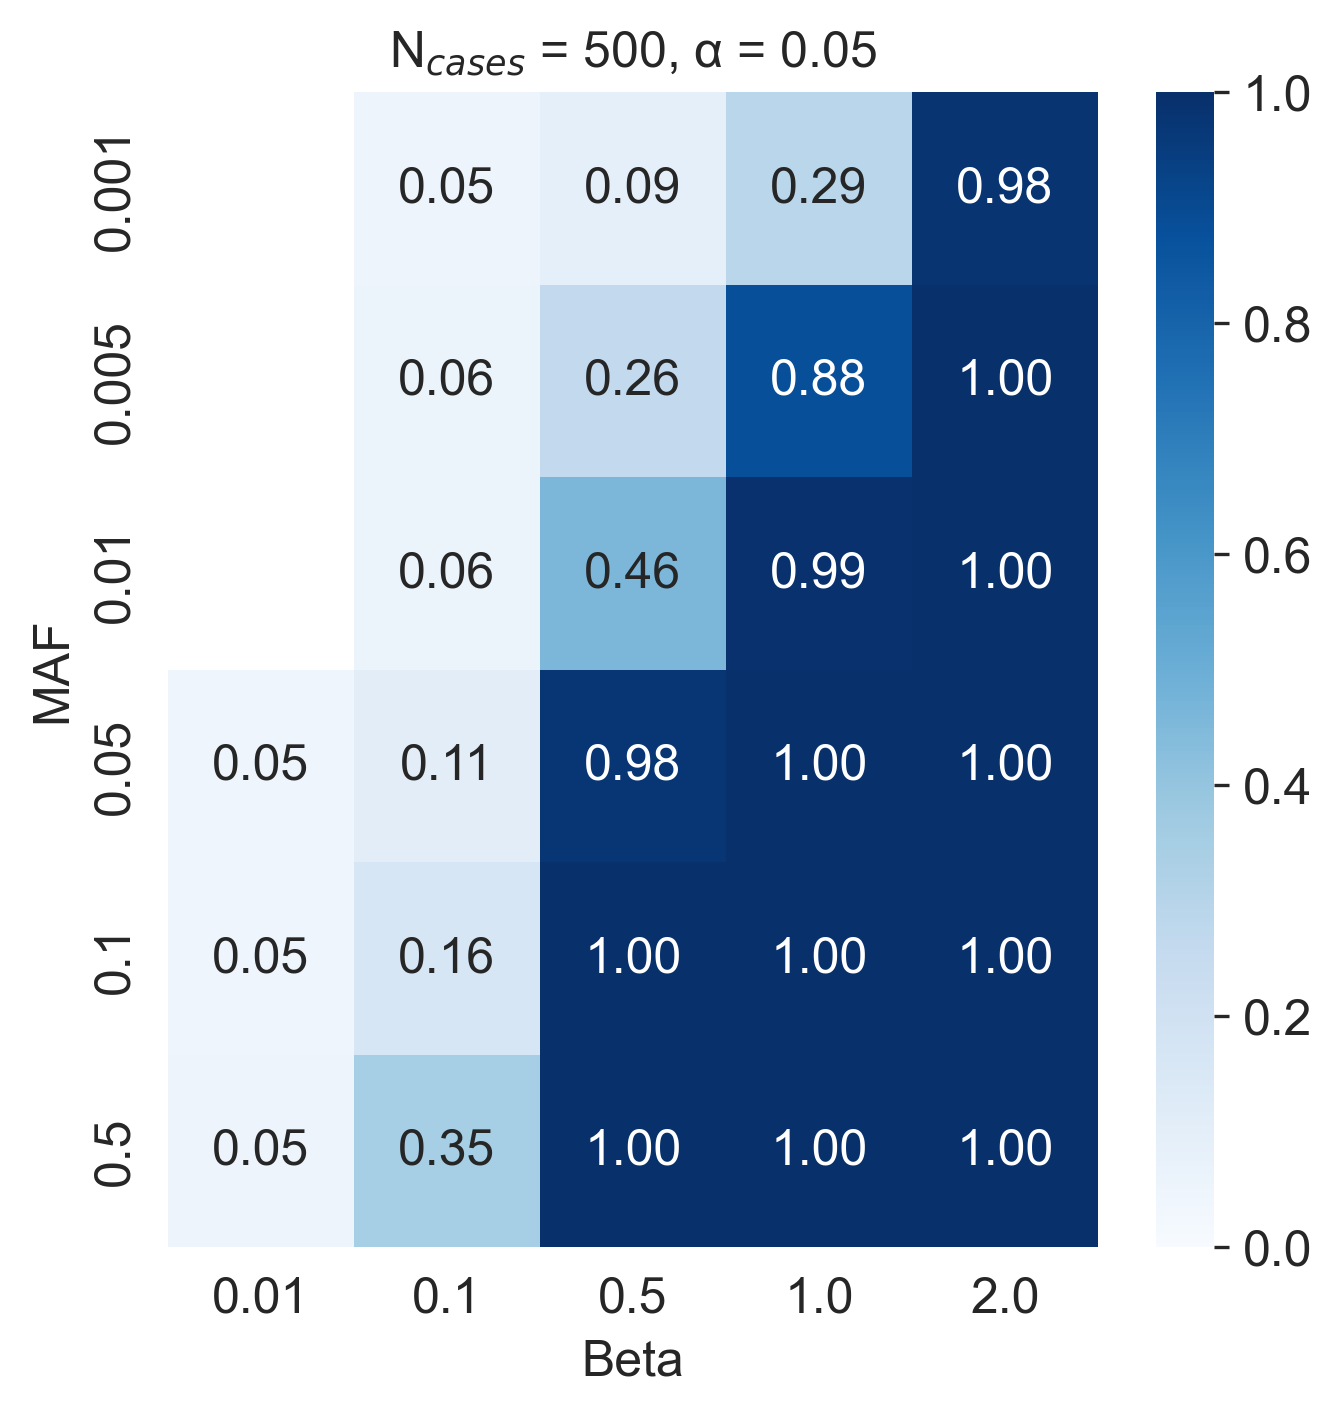

In [39]:
df = power.loc[power['N_cases'] == 500]
df['Beta'] = np.log(df['OR'])
df['Beta'] = df['Beta'].apply(lambda x: np.round(x, -int(np.floor(np.log10(abs(x))))))
df = pd.pivot_table(df, index='MAF', columns='Beta', values='Power_at_Alpha_0.05')

plt.figure(figsize=(5,5), dpi=300)
sns.set_style('white')

sns.heatmap(df, cmap='Blues', vmin=0, annot=True, fmt=".2f")

plt.title('N$_{cases}$ = 500, α = 0.05')
plt.xlabel('Beta')
plt.ylabel('MAF')


/tmp/ipykernel_11275/3816142316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Beta'] = np.log(df['OR'])
/tmp/ipykernel_11275/3816142316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Beta'] = df['Beta'].apply(lambda x: np.round(x, -int(np.floor(np.log10(abs(x))))))


Text(95.66666666666667, 0.5, 'MAF')

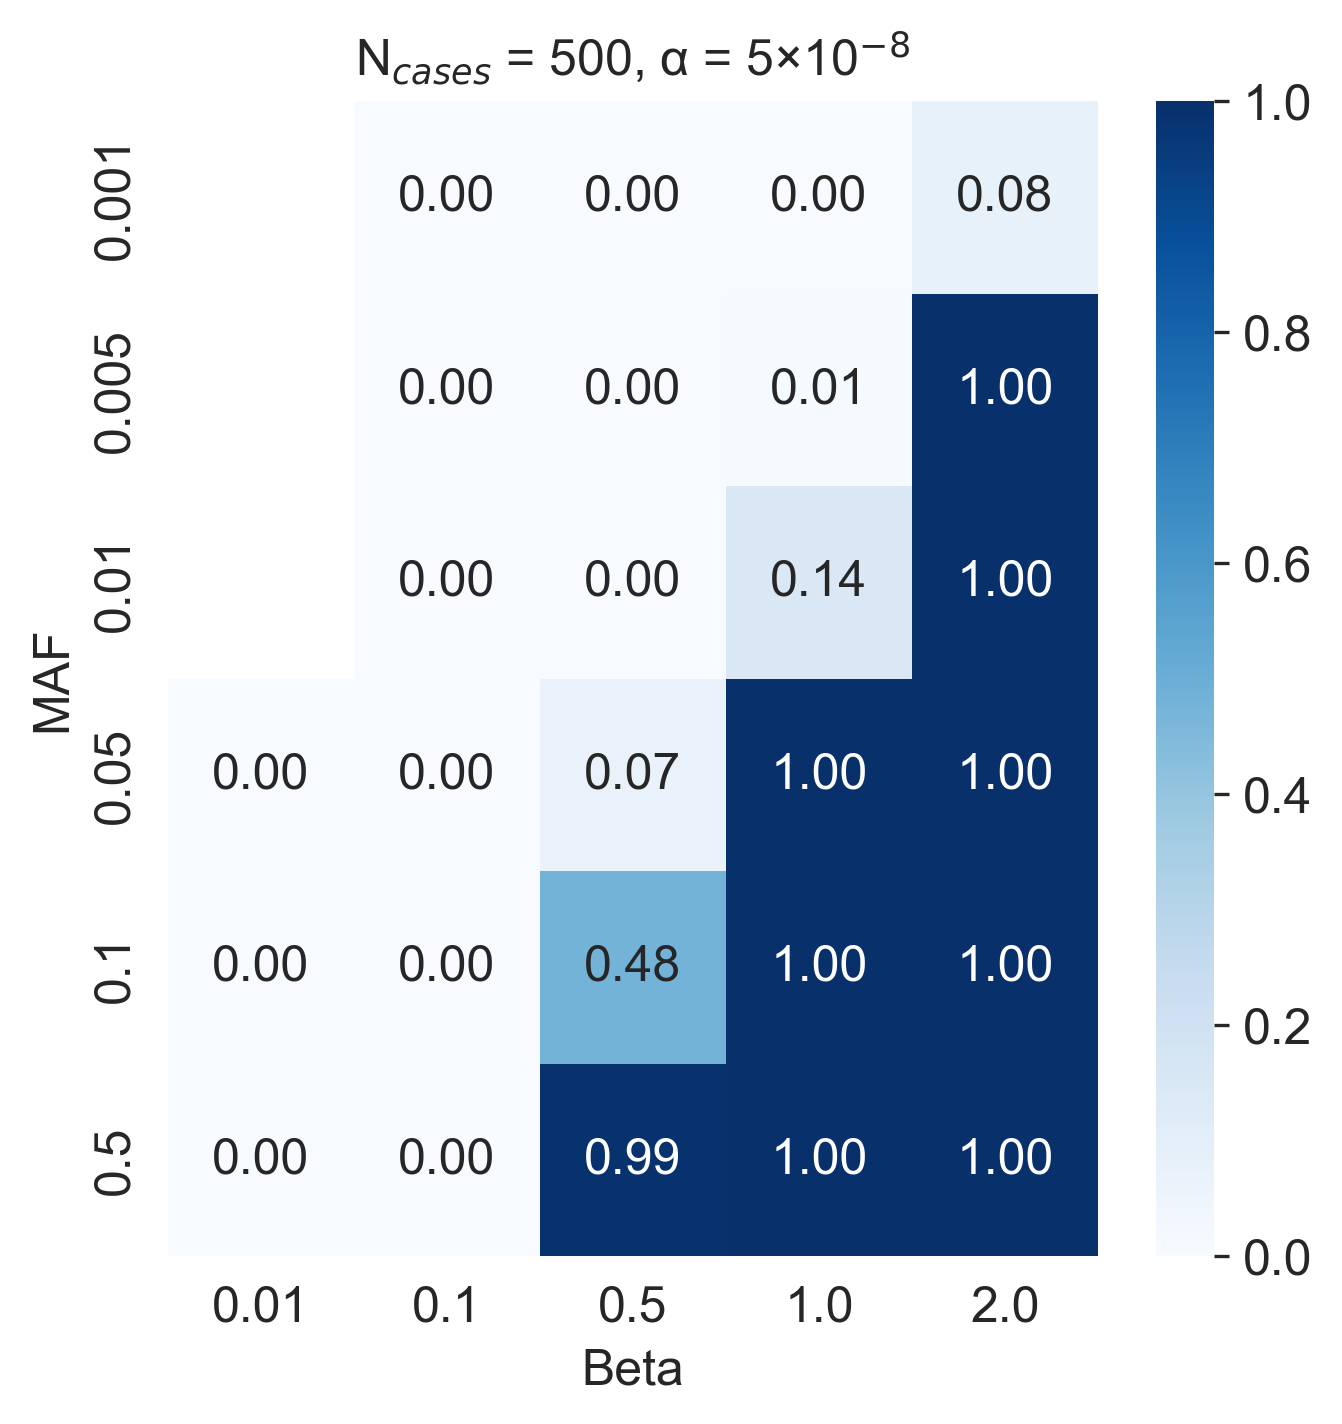

In [40]:
df = power.loc[power['N_cases'] == 500]
df['Beta'] = np.log(df['OR'])
df['Beta'] = df['Beta'].apply(lambda x: np.round(x, -int(np.floor(np.log10(abs(x))))))
df = pd.pivot_table(df, index='MAF', columns='Beta', values='Power_at_Alpha_5e-08')

plt.figure(figsize=(5,5), dpi=300)
sns.set_style('white')

sns.heatmap(df, cmap='Blues', vmin=0, annot=True, fmt=".2f")

plt.title('N$_{cases}$ = 500, α = 5×10$^{-8}$')
plt.xlabel('Beta')
plt.ylabel('MAF')


## Figure 2

In [4]:
alldata = pd.read_pickle('./Final/ml_input.pkl')
alldata['clin_all'] = alldata[['clin_ot','hgmd']].max(axis=1)
alldata = alldata[['gene','phecode','indication','clin_all','gwas_credible_sets','gene_burden','mantis',
                   'cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']]

alldata = alldata.loc[(alldata['cc_common_max_p'] > -np.log10(5e-8)) | (alldata['cc_rare_max_p'] > -np.log10(4.3e-7))
                        | (alldata['cc_rare_burden_max_p'] > -np.log10(0.05/18500)) | (alldata['cc_ultrarare_max_p'] > -np.log10(0.05/18500))]

amelie = pd.read_pickle('./AMELIE/amelie_output_aggregated.pkl')
amelie = amelie[['gene','phecode','score']].rename({'score':'amelie'},axis=1)
alldata = alldata.merge(amelie, how='left').fillna(0)

alldata = alldata.merge(rd[['phecode','phecode_string','count_all']])


In [5]:
temp = alldata[['phecode','phecode_string','gene','cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']]
for col in ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']:
    temp.loc[temp[col] >= 0, col] = 10**(-temp[col])
temp = temp.sort_values(['phecode','gene'])
temp.to_excel('./Results/sig_associations.xlsx', index=False)

print(len(temp[['phecode','gene']].drop_duplicates()))
print(temp['phecode'].nunique(), temp['gene'].nunique())


451
139 399


In [28]:
ab = alldata.copy()
for col in ['clin_all','gwas_credible_sets','gene_burden','mantis','amelie']:
    ab.loc[ab[col] > 0, col] = 1
ab['any'] = ab[['clin_all','gwas_credible_sets','gene_burden','mantis','amelie']].max(axis=1)
ab['pg'] = ab[['gwas_credible_sets','gene_burden']].max(axis=1)
ab['all'] = 1
ab['unsupported'] = 0
ab.loc[ab['any'] == 0, 'unsupported'] = 1

# Drug indications supported by Bonferroni-significant associations
print(len(ab.loc[ab['indication'] == 1]))


10


In [8]:
res = pd.DataFrame()

a = ab.loc[ab['cc_common_max_p'] > -np.log10(5e-8)][['all','unsupported','clin_all','pg','mantis','amelie','any']].sum()
a = a.reset_index().set_axis(['Variable','Count'],axis=1)
a['Analysis'] = 'Common variants'
res = pd.concat([res,a])

a = ab.loc[ab['cc_rare_max_p'] > -np.log10(4.3e-7)][['all','unsupported','clin_all','pg','mantis','amelie','any']].sum()
a = a.reset_index().set_axis(['Variable','Count'],axis=1)
a['Analysis'] = 'Rare variants'
res = pd.concat([res,a])

a = ab.loc[ab['cc_rare_burden_max_p'] > -np.log10(0.05/17441)][['all','unsupported','clin_all','pg','mantis','amelie','any']].sum()
a = a.reset_index().set_axis(['Variable','Count'],axis=1)
a['Analysis'] = 'Rare variants (gene-level)'
res = pd.concat([res,a])

a = ab.loc[ab['cc_ultrarare_max_p'] > -np.log10(0.05/18285)][['all','unsupported','clin_all','pg','mantis','amelie','any']].sum()
a = a.reset_index().set_axis(['Variable','Count'],axis=1)
a['Analysis'] = 'Ultrarare variants (gene-level)'
res = pd.concat([res,a])


In [9]:
res.loc[res['Variable'] == 'all']

,Variable,Count,Analysis
0,all,112.0,Common variants
0,all,271.0,Rare variants
0,all,52.0,Rare variants (gene-level)
0,all,51.0,Ultrarare variants (gene-level)


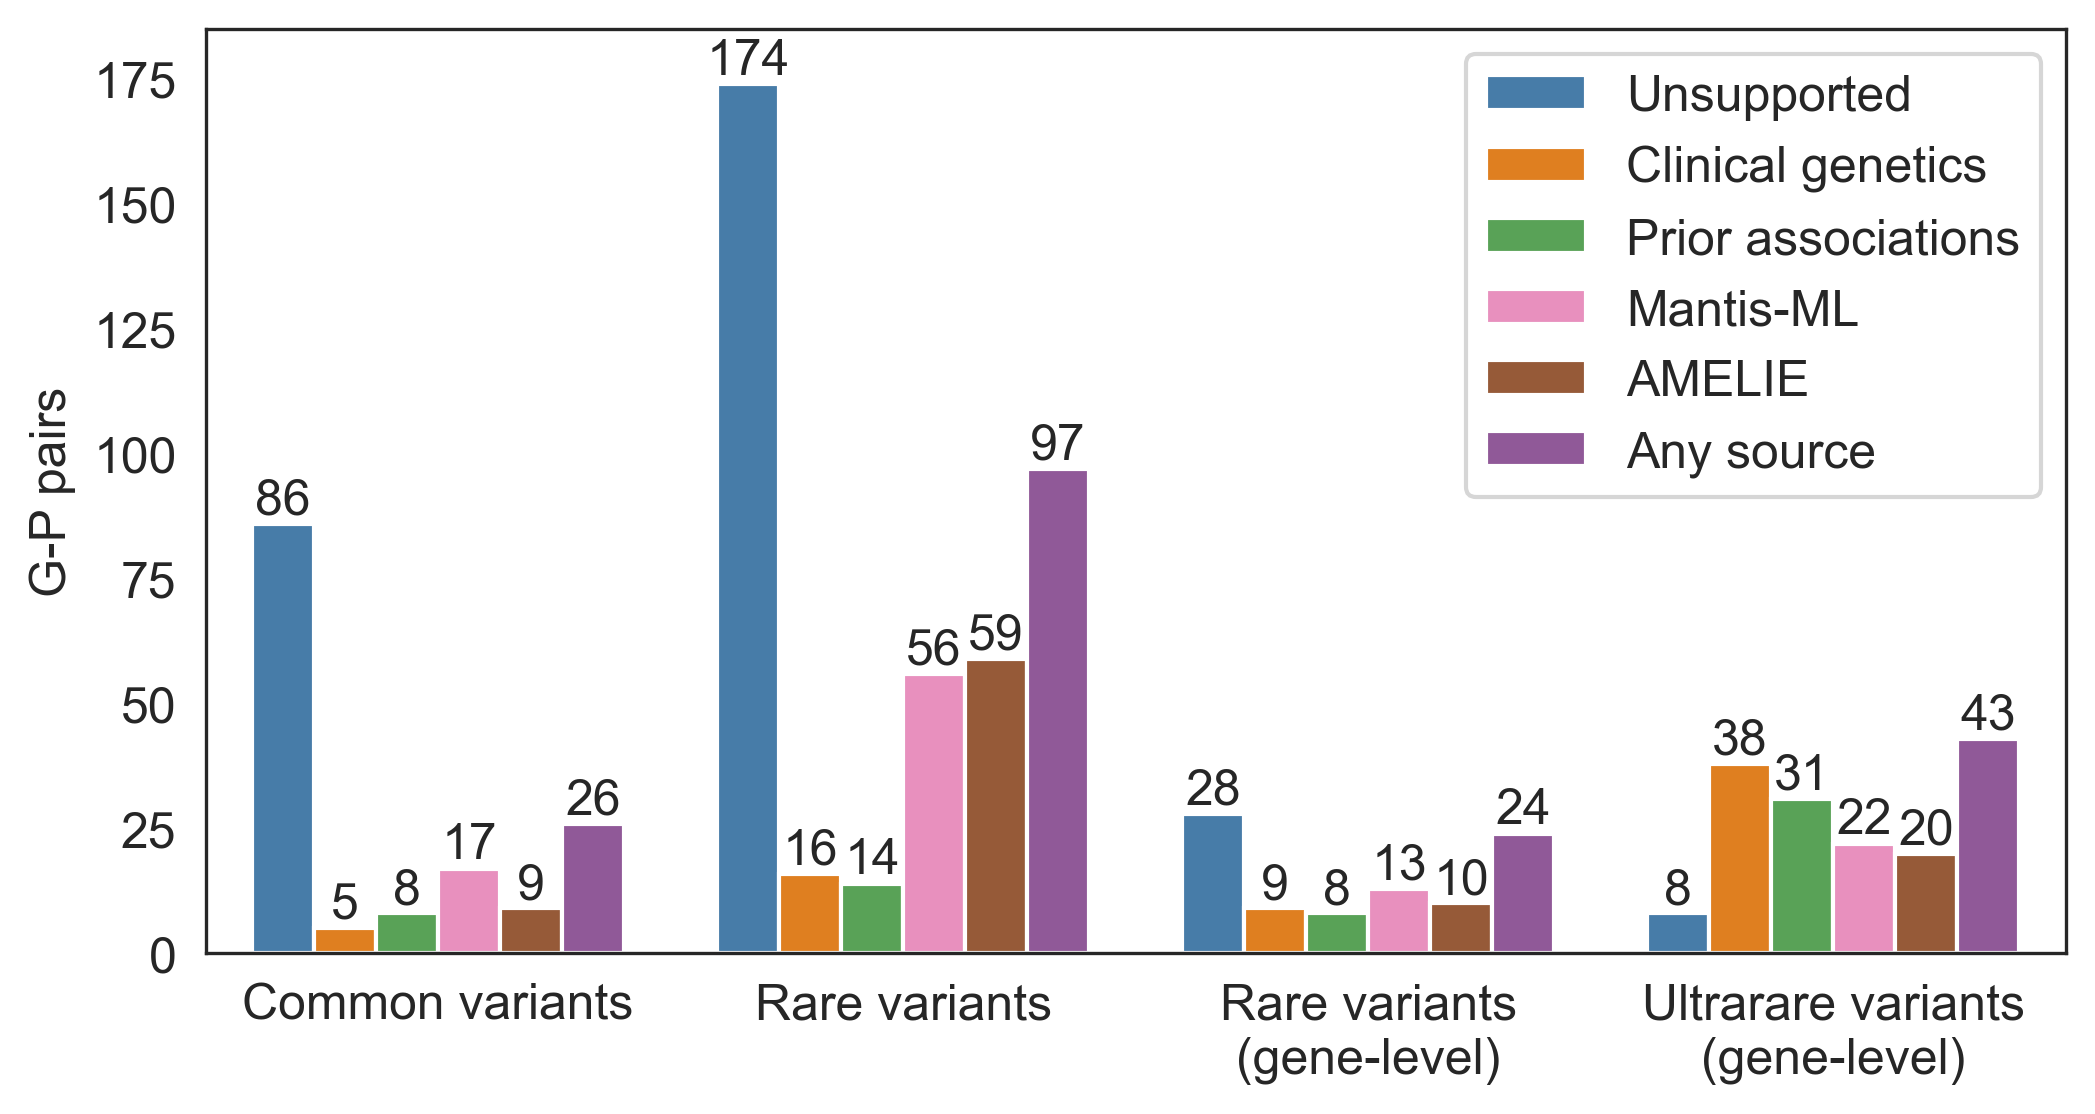

In [10]:
pdf = res.copy()
pdf = pdf.loc[pdf['Variable'] != 'all']
pdf['Variable'] = pdf['Variable'].map({'unsupported':'Unsupported','clin_all':'Clinical genetics','pg':'Prior associations',
                                       'mantis':'Mantis-ML','amelie':'AMELIE','any':'Any source'})

plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

ax = sns.barplot(pdf, x='Analysis', y='Count', hue='Variable', palette=CB_color_cycle)
for container in ax.containers:
    ax.bar_label(container)

dl = ['Common variants','Rare variants','Rare variants\n(gene-level)','Ultrarare variants\n(gene-level)']
plt.xticks(np.arange(len(dl)), dl, rotation=0, ha='center')

plt.xlabel('')
plt.ylabel('G-P pairs')
plt.ylim([0,185])
plt.legend(title='')

In [11]:
indata = pd.read_pickle('./Final/ml_input.pkl')
indata = indata.loc[(indata['drug_gene'] == 1)]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]

indata = indata[['id','indication','phecode_category','cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']]

pc = indata.drop('phecode_category',axis=1)
pc = pd.melt(pc, id_vars=['id','indication'])
pc['indication'] = pc['indication'].map({0:'Non-indicated',1:'Indicated'})

indata['cc_common_max_p'] = indata['cc_common_max_p'].fillna(0)

indata['c05'] = 0
indata.loc[indata['cc_common_max_p'] >= 1.301, 'c05'] += 1
indata.loc[(indata['cc_rare_max_p'] >= 1.301) | (indata['cc_rare_burden_max_p'] >= 1.301), 'c05'] += 1
indata.loc[indata['cc_ultrarare_max_p'] >= 1.301, 'c05'] += 1

if True:
    indata['c01'] = 0
    indata.loc[indata['cc_common_max_p'] >= 2, 'c01'] += 1
    indata.loc[(indata['cc_rare_max_p'] >= 2) | (indata['cc_rare_burden_max_p'] >= 2), 'c01'] += 1
    indata.loc[indata['cc_ultrarare_max_p'] >= 2, 'c01'] += 1

    indata['c001'] = 0
    indata.loc[indata['cc_common_max_p'] >= 3, 'c001'] += 1
    indata.loc[(indata['cc_rare_max_p'] >= 3) | (indata['cc_rare_burden_max_p'] >= 3), 'c001'] += 1
    indata.loc[indata['cc_ultrarare_max_p'] >= 3, 'c001'] += 1
    

In [12]:
for variable in ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']:
    a = pc.loc[pc['variable'] == variable]
    print(a.dropna()['indication'].value_counts())
    b = a.loc[a['indication'] == 'Indicated']['value'].dropna().to_list()
    c = a.loc[a['indication'] == 'Non-indicated']['value'].dropna().to_list()
    print(variable, ranksums(b,c))

indication
Non-indicated    196597
Indicated          3503
Name: count, dtype: int64
cc_common_max_p RanksumsResult(statistic=np.float64(6.298784110959481), pvalue=np.float64(2.999894647875674e-10))
indication
Non-indicated    338112
Indicated          5728
Name: count, dtype: int64
cc_rare_max_p RanksumsResult(statistic=np.float64(-0.8611117747015122), pvalue=np.float64(0.3891764847288649))
indication
Non-indicated    314852
Indicated          5236
Name: count, dtype: int64
cc_rare_burden_max_p RanksumsResult(statistic=np.float64(-0.18536093705386847), pvalue=np.float64(0.8529459451633427))
indication
Non-indicated    331993
Indicated          5575
Name: count, dtype: int64
cc_ultrarare_max_p RanksumsResult(statistic=np.float64(10.78828773409521), pvalue=np.float64(3.91006552072946e-27))


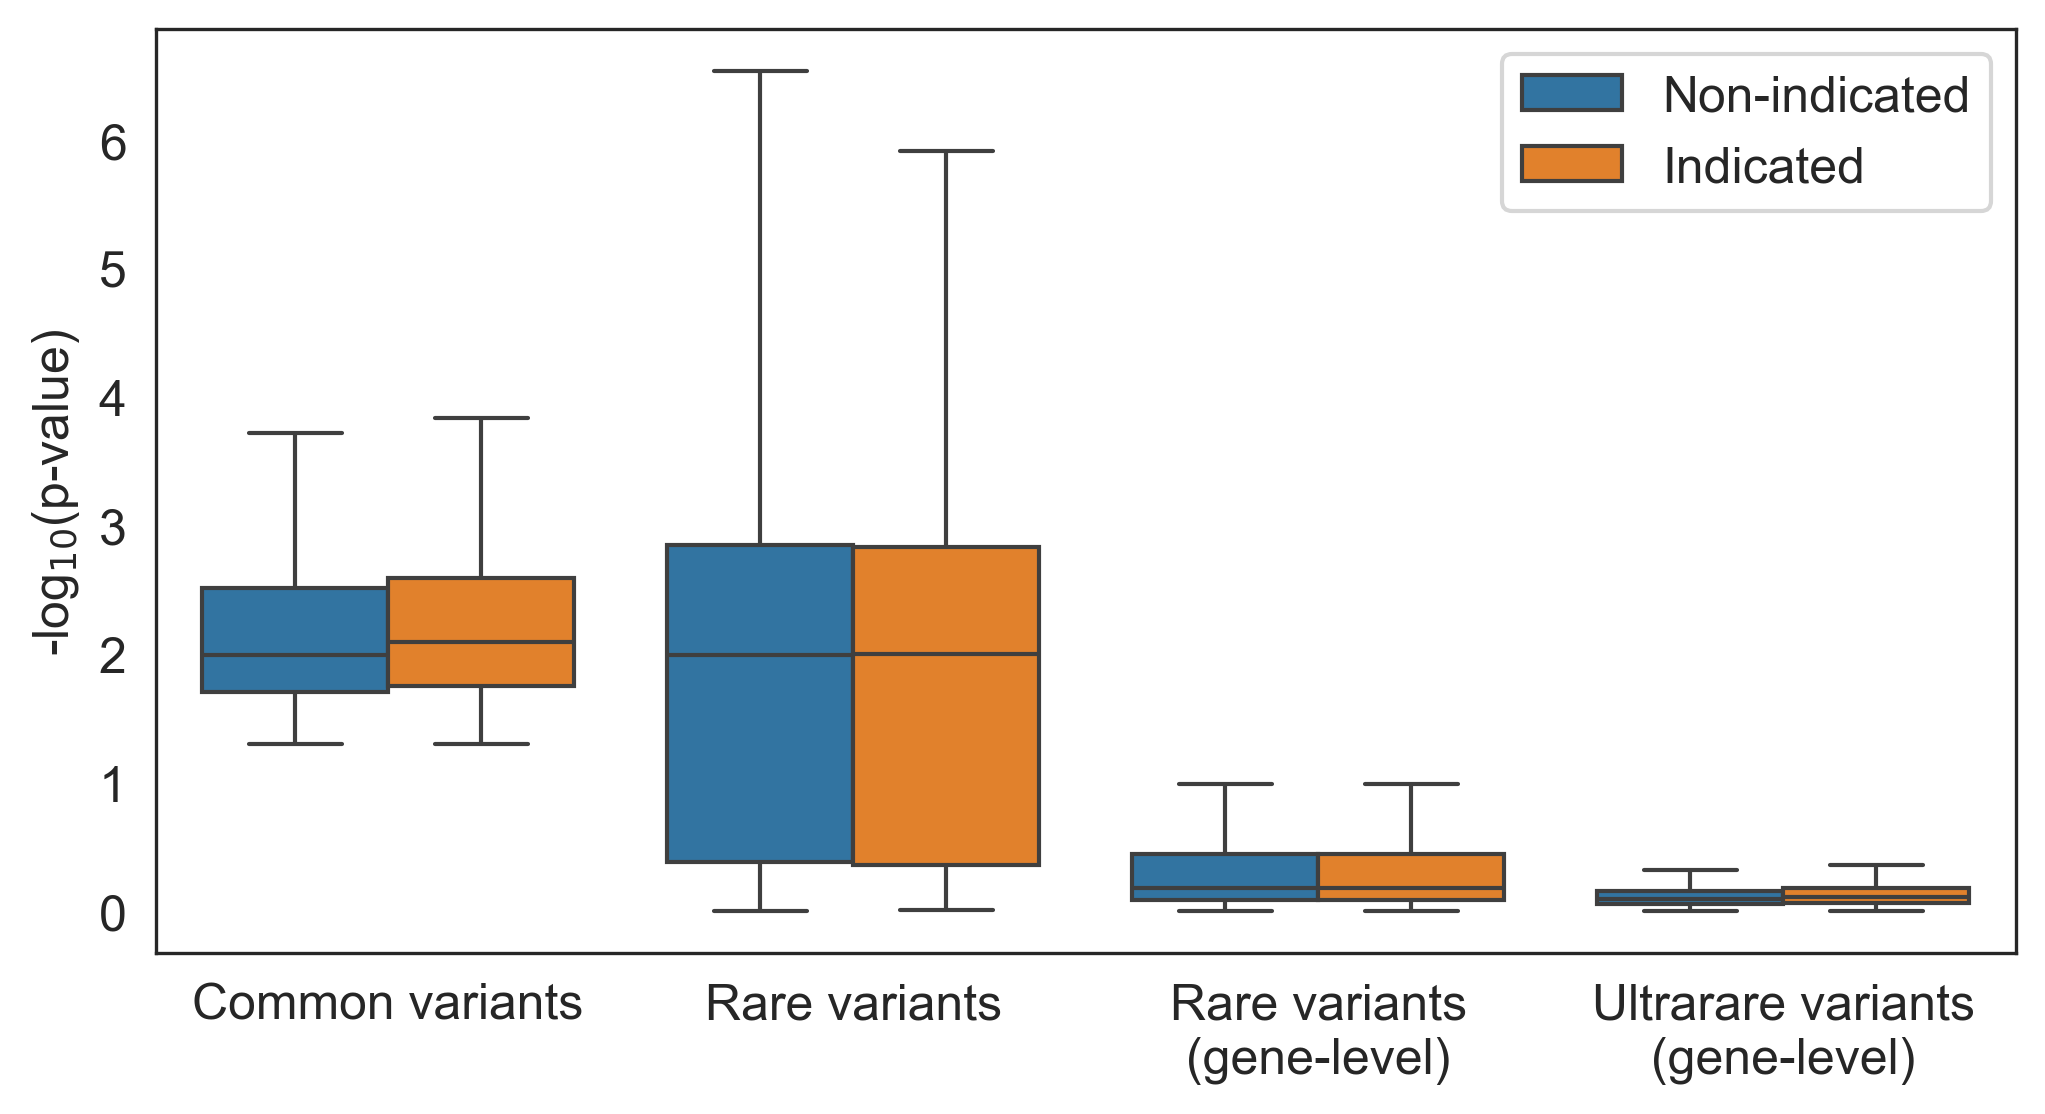

In [13]:
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

sns.boxplot(pc, x='variable', y='value', hue='indication', showfliers=False)

dl = ['Common variants','Rare variants','Rare variants\n(gene-level)','Ultrarare variants\n(gene-level)']
plt.xticks(np.arange(len(dl)), dl, rotation=0, ha='center')

plt.xlabel('')
plt.ylabel('-log$_{10}$(p-value)')
plt.legend(title='')


In [30]:
results = []
feat_cols = ['c05','c01']
lr_df = indata[['phecode_category','indication'] + feat_cols].reset_index(drop=True)
# thresh_cols = [-np.log10(5e-8),-np.log10(4.3e-7),-np.log10(0.05/17441),-np.log10(0.05/18285)]

for thresh in [1,2,3]:
    for i, col in enumerate(feat_cols):
        temp = lr_df.dropna(subset=[col])
        temp.loc[temp['c05'] == 0, 'binary'] = 0
        temp.loc[temp[col] == thresh, 'binary'] = 1
        temp = temp.loc[temp['binary'].isin([0,1])]
        X = temp[['phecode_category','binary']]
        X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
        X = sm.add_constant(X)
        y = temp['indication']
        
        model = sm.Logit(y, X)
        res = model.fit(disp=0, maxiter=500)
        
        odds_ratio = np.exp(res.params['binary'])
        conf = res.conf_int().loc['binary']
        conf_odds_ratio = np.exp(conf)
        p_value = res.pvalues['binary']
        
        results.append({
            'Column': col,
            'Threshold': thresh,
            'Count': len(temp.loc[temp['binary'] == 1]),
            'Indicated': len(temp.loc[(temp['indication'] == 1) & (temp['binary'] == 1)]),
            'Odds Ratio': odds_ratio, '95% Lower': conf_odds_ratio[0], '95% Upper': conf_odds_ratio[1],
            'p-value': p_value
        })

df = pd.DataFrame(results)
df['Column'] = df['Column'].map({'c05':'p < 0.05','c01':'p < 0.01'})
df


,Column,Threshold,Count,Indicated,Odds Ratio,95% Lower,95% Upper,p-value
0,p < 0.05,1,150063,2423,1.030051,0.957607,1.107976,0.426177
1,p < 0.01,1,163102,2723,1.069958,0.995791,1.149648,0.065054
2,p < 0.05,2,130805,2281,1.113538,1.034156,1.199013,0.004371
3,p < 0.01,2,55276,1049,1.219542,1.117874,1.330456,0.000008
4,p < 0.05,3,7758,140,1.174945,0.981932,1.405897,0.078269
5,p < 0.01,3,767,23,2.001330,1.312052,3.052716,0.001279


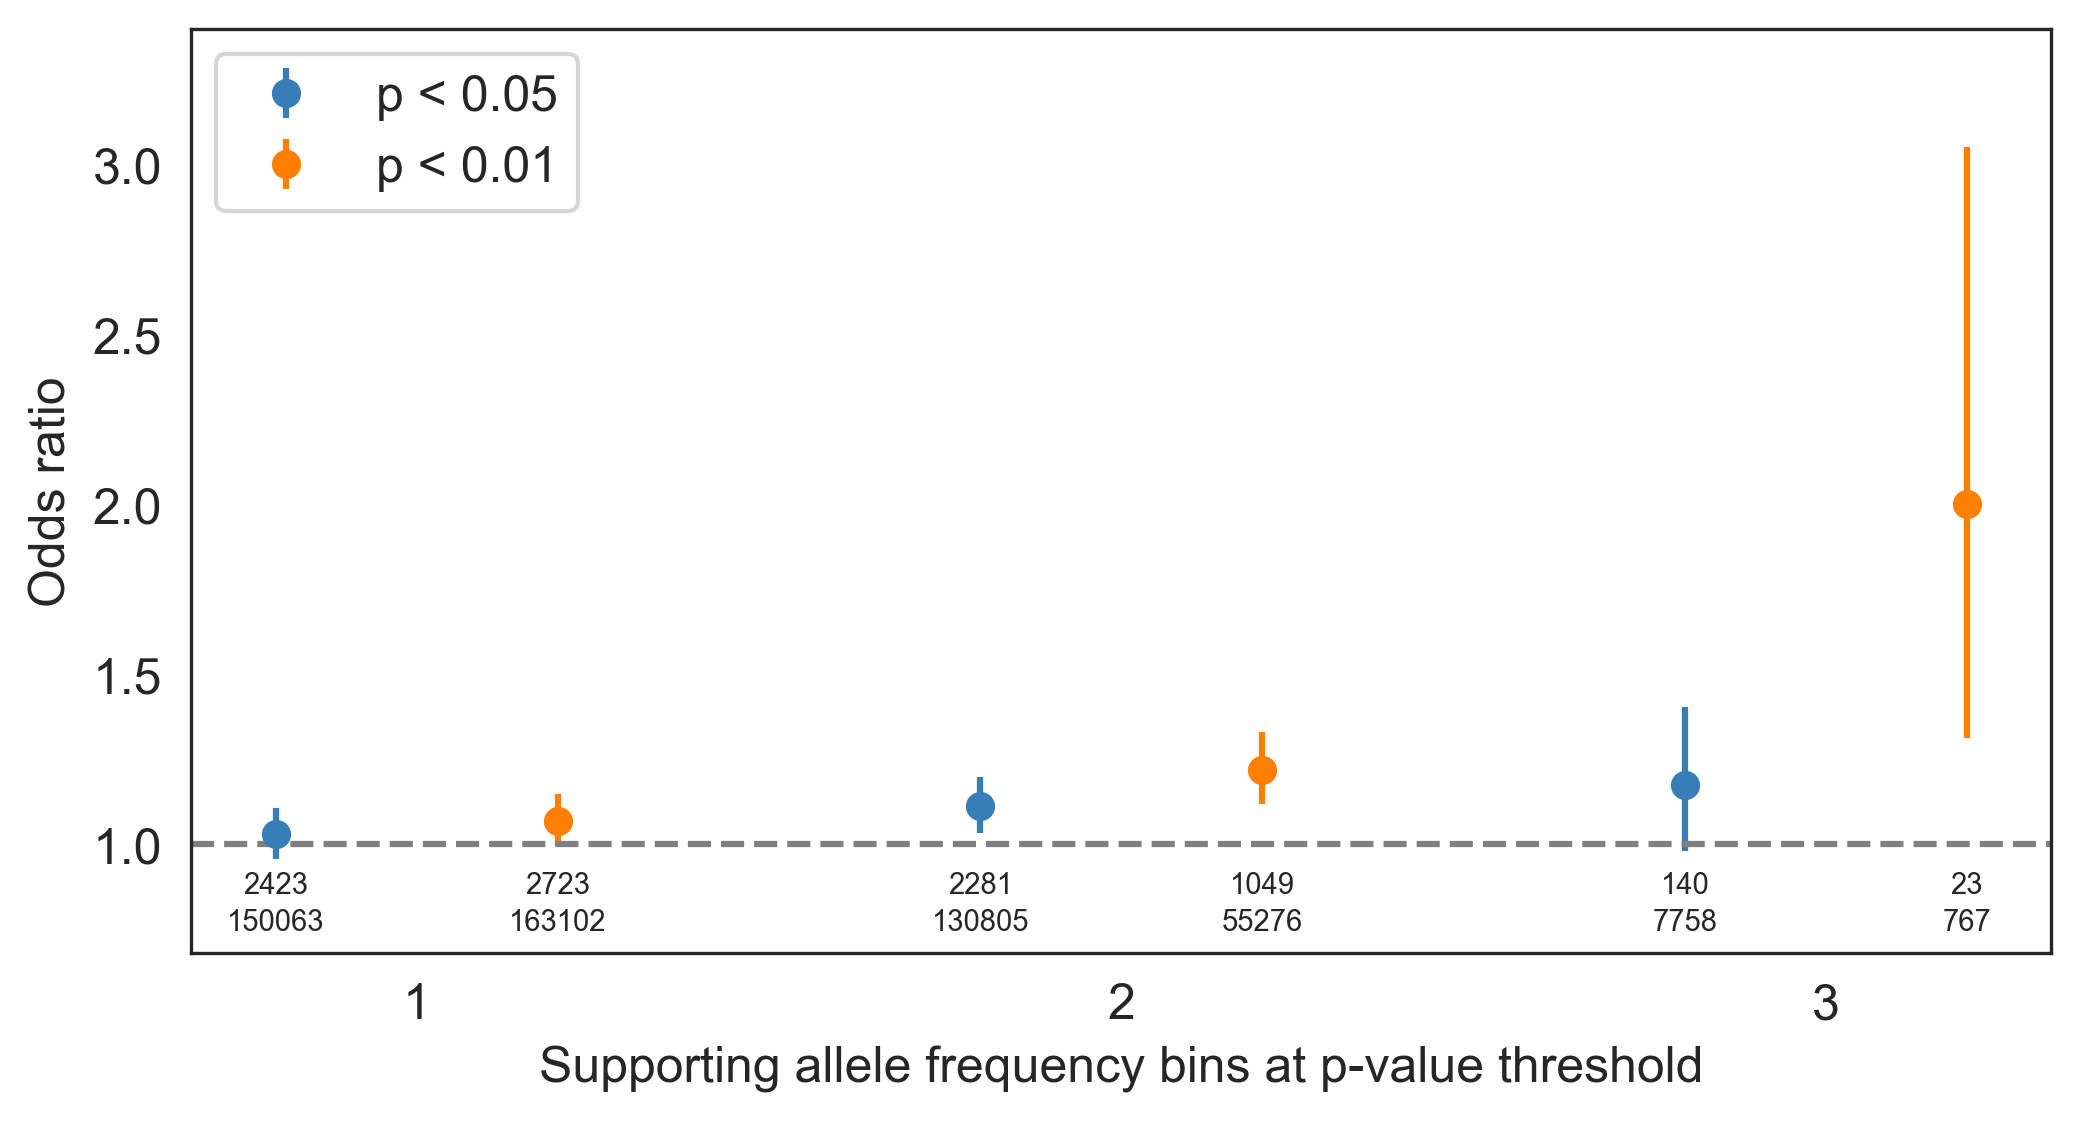

In [15]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['Odds Ratio'] - df['95% Lower']
df['error_upper'] = df['95% Upper'] - df['Odds Ratio']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Threshold'].unique()
models = df['Column'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.4  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Column'] == model]
    x_positions = x + (i - (len(models)-1)/2)*width
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['Odds Ratio'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])
    for j in range(len(model_data)):
        plt.text(x_positions[j], 0.88, str(model_data['Indicated'].iloc[j]), ha='center', va='center', size = 7)
        plt.text(x_positions[j], 0.77, str(model_data['Count'].iloc[j]), ha='center', va='center', size = 7)

plt.xticks(ticks=x, labels=datasets)

dl = ['1','2','3']
plt.xticks(np.arange(len(dl)), dl, rotation=0, ha='center')

plt.xlabel('Supporting allele frequency bins at p-value threshold')
plt.ylabel('Odds ratio')
plt.ylim([0.68,3.4])
plt.title('')
plt.legend(loc='upper left')

plt.axhline(y=1, color='gray', linestyle='--')

plt.show()


In [32]:
results = []
feat_cols = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']
lr_df = indata[['phecode_category','indication'] + feat_cols].reset_index(drop=True)
# thresh_cols = [-np.log10(5e-8),-np.log10(4.3e-7),-np.log10(0.05/17441),-np.log10(0.05/18285)]

thresholds = [
    (-np.log10(0.05), -np.log10(1e-2), '1×10$^{-2}$ ≤ p < 0.05'),
    (-np.log10(1e-2), -np.log10(1e-3), '1×10$^{-3}$ ≤ p < 1×10$^{-2}$'),
    (-np.log10(1e-3), -np.log10(1e-5), '1×10$^{-5}$ ≤ p < 1×10$^{-3}$'),
    (-np.log10(1e-5), np.inf, 'p < 1×10$^{-5}$')
]

for thresh1, thresh2, label in thresholds:
    for i, col in enumerate(feat_cols):
        temp = lr_df.dropna(subset=[col])
        temp.loc[temp[col] <= -np.log10(0.05), col] = 0
        temp.loc[temp[col] > thresh1, col] = 1
        temp.loc[temp[col] > thresh2, col] = 2
        temp = temp.loc[temp[col].isin([0,1])]
        X = temp[['phecode_category'] + [col]]
        X = pd.get_dummies(X, columns=['phecode_category'], drop_first=True).astype(float)
        X = sm.add_constant(X)
        y = temp['indication']
        
        model = sm.Logit(y, X)
        res = model.fit(disp=0, maxiter=500)
        
        odds_ratio = np.exp(res.params[col])
        conf = res.conf_int().loc[col]
        conf_odds_ratio = np.exp(conf)
        p_value = res.pvalues[col]
        
        results.append({
            'Column': col,
            'Threshold': label, 'Threshold 1': thresh1, 'Threshold 2': thresh2,
            'Count': len(temp.loc[temp[col] == 1]),
            'Indicated': len(temp.loc[(temp['indication'] == 1) & (temp[col] == 1)]),
            'Odds Ratio': odds_ratio, '95% Lower': conf_odds_ratio[0], '95% Upper': conf_odds_ratio[1],
            'p-value': p_value
        })

df = pd.DataFrame(results)
df


,Column,Threshold,Threshold 1,Threshold 2,Count,Indicated,Odds Ratio,95% Lower,95% Upper,p-value
0,cc_common_max_p,1×10$^{-2}$ ≤ p < 0.05,1.30103,2.0,200100,3503,1.139995,1.081729,1.201400,9.837167e-07
1,cc_rare_max_p,1×10$^{-2}$ ≤ p < 0.05,1.30103,2.0,217662,3593,0.980934,0.928767,1.036030,4.899196e-01
2,cc_rare_burden_max_p,1×10$^{-2}$ ≤ p < 0.05,1.30103,2.0,31365,500,0.973825,0.887176,1.068936,5.769388e-01
3,cc_ultrarare_max_p,1×10$^{-2}$ ≤ p < 0.05,1.30103,2.0,17155,307,1.086983,0.967403,1.221343,1.607217e-01
4,cc_common_max_p,1×10$^{-3}$ ≤ p < 1×10$^{-2}$,2.00000,3.0,99083,1912,1.257083,1.182945,1.335867,1.617684e-13
5,cc_rare_max_p,1×10$^{-3}$ ≤ p < 1×10$^{-2}$,2.00000,3.0,171429,2870,0.998245,0.942720,1.057041,9.520435e-01
6,cc_rare_burden_max_p,1×10$^{-3}$ ≤ p < 1×10$^{-2}$,2.00000,3.0,14015,224,0.972953,0.849671,1.114121,6.916196e-01
7,cc_ultrarare_max_p,1×10$^{-3}$ ≤ p < 1×10$^{-2}$,2.00000,3.0,5382,105,1.189910,0.978356,1.447209,8.170346e-02
8,cc_common_max_p,1×10$^{-5}$ ≤ p < 1×10$^{-3}$,3.00000,5.0,21005,425,1.319610,1.188436,1.465261,2.082713e-07
9,cc_rare_max_p,1×10$^{-5}$ ≤ p < 1×10$^{-3}$,3.00000,5.0,69483,1113,0.939713,0.873011,1.011511,9.786816e-02


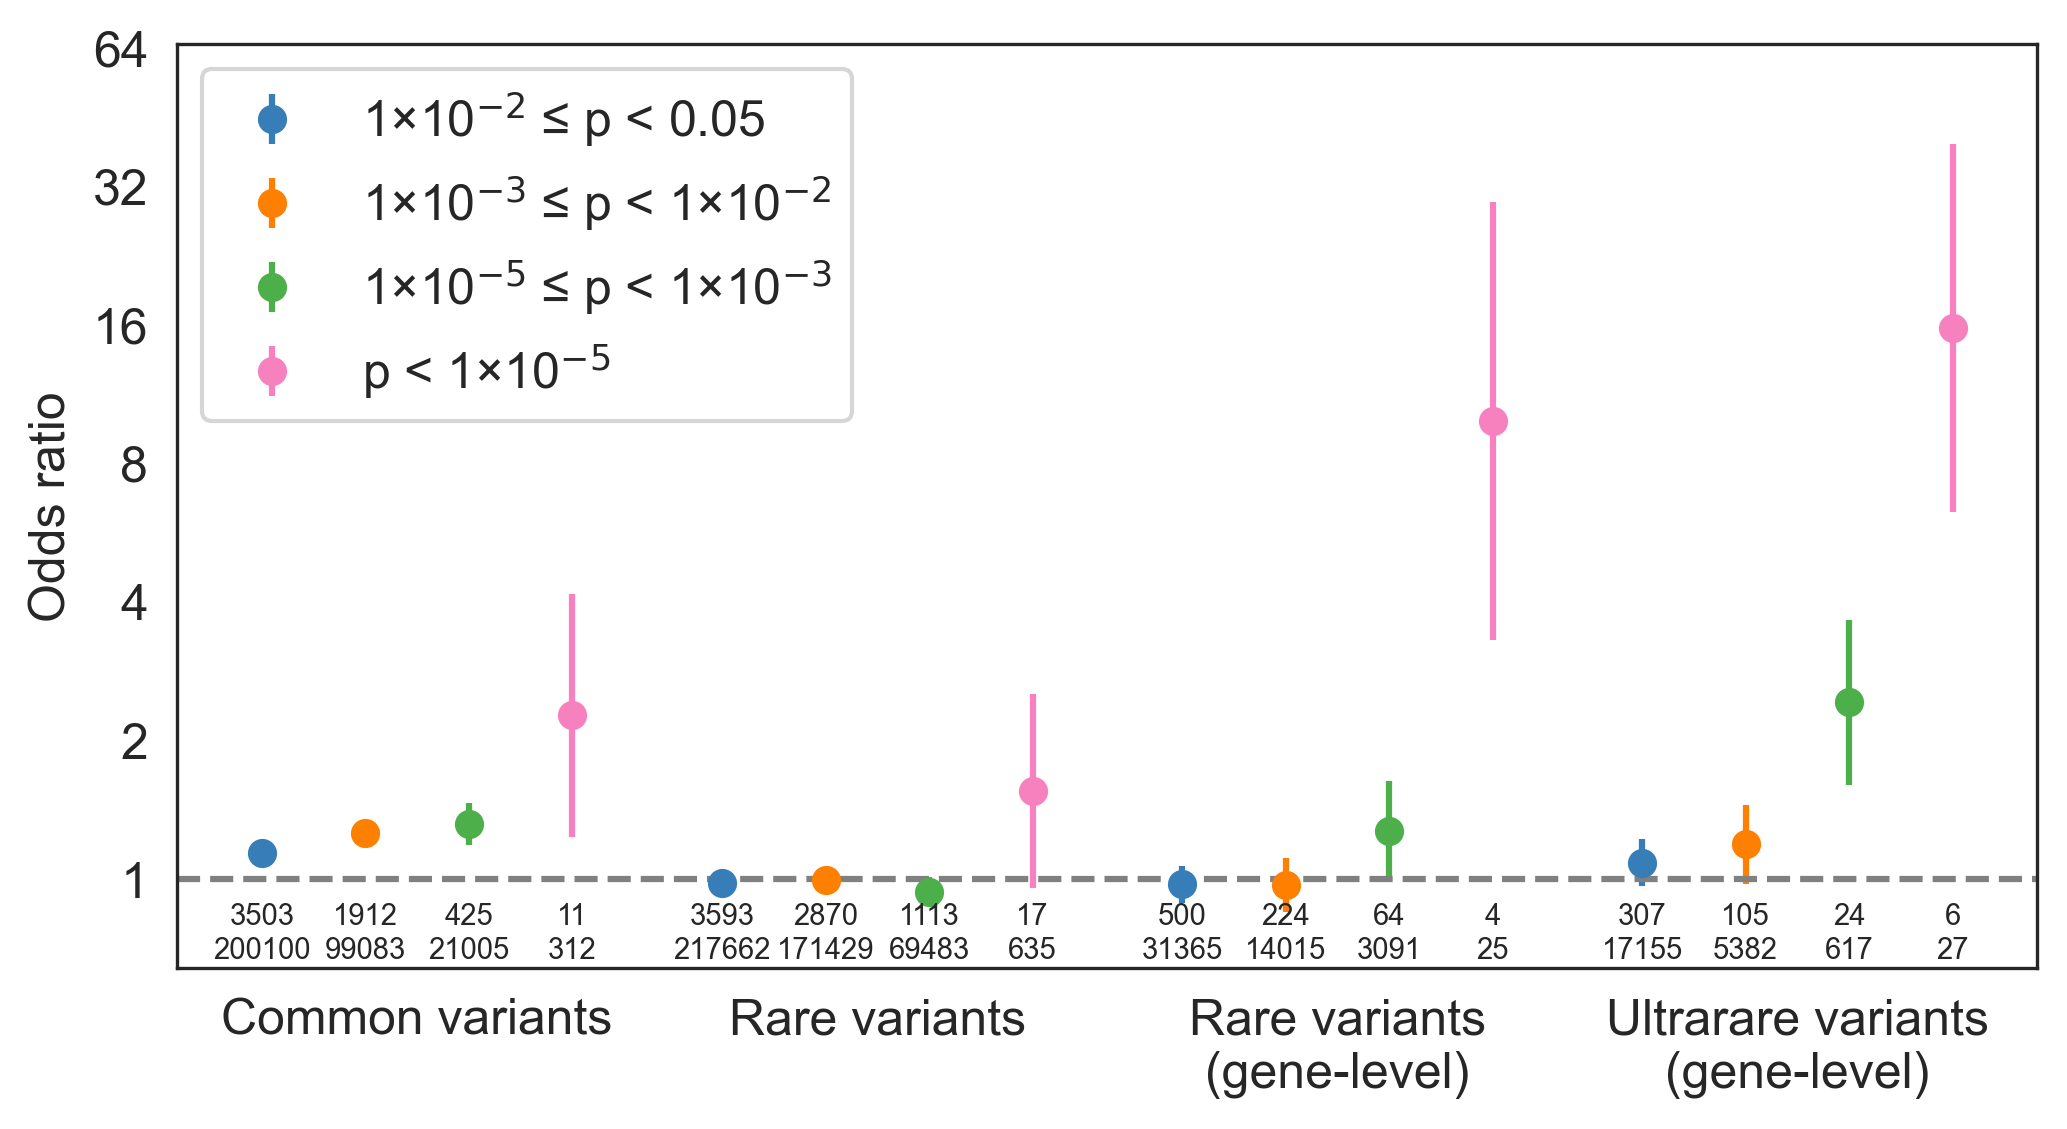

In [33]:
# Calculate error (difference between mean and bounds)
df['error_lower'] = df['Odds Ratio'] - df['95% Lower']
df['error_upper'] = df['95% Upper'] - df['Odds Ratio']

# Create the plot
plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

# Define the unique datasets and models
datasets = df['Column'].unique()
models = df['Threshold'].unique()

# Generate x positions for each dataset and dodge positions for models
x = np.arange(len(datasets))
width = 0.225  # Width for dodging

# Plot data points with dodging between models
for i, model in enumerate(models):
    model_data = df[df['Threshold'] == model]
    x_positions = x + (i - (len(models)-1)/2)*width
    plt.errorbar(x=x + (i - (len(models) - 1) / 2) * width, 
                 y=model_data['Odds Ratio'], 
                 yerr=[model_data['error_lower'], model_data['error_upper']], 
                 fmt='o', capsize=0, label=model, color=CB_color_cycle[i])
    for j in range(len(model_data)):
        plt.text(x_positions[j], 0.83, str(model_data['Indicated'].iloc[j]), ha='center', va='center', size=7)
        plt.text(x_positions[j], 0.70, str(model_data['Count'].iloc[j]), ha='center', va='center', size=7)
        
plt.xticks(ticks=x, labels=datasets)

dl = ['Common variants','Rare variants','Rare variants\n(gene-level)','Ultrarare variants\n(gene-level)']
plt.xticks(np.arange(len(dl)), dl, rotation=0, ha='center')

plt.ylabel('Odds ratio')
plt.title('')
plt.legend(loc='upper left')
plt.ylim([0.64,65])

plt.yscale('log', base=2)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):d}'))

plt.axhline(y=1, color='gray', linestyle='--')

plt.show()
